In [110]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [111]:
#Reading data
filepth = "../public_cases.json"
with open(filepth, 'r') as f:
    data = json.load(f)
df = pd.json_normalize(data)
df.columns = df.columns.str.replace('input.', '', regex=False)

In [119]:
#Creating y, X, train test split etc
X = df.drop('expected_output', axis=1).values
y = df['expected_output'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train.astype('float32'))
y_train_tensor = torch.tensor(y_train.astype('float32')).view(-1, 1)
X_test_tensor = torch.tensor(X_test.astype('float32'))
y_test_tensor = torch.tensor(y_test.astype('float32')).view(-1, 1)

In [120]:
y_train_tensor

tensor([[1658.9700],
        [1809.9100],
        [1281.6400],
        [1372.3101],
        [1277.2600],
        [ 862.6100],
        [1913.8700],
        [ 837.8000],
        [ 801.7300],
        [1921.6801],
        [1798.3800],
        [1413.5200],
        [1925.3199],
        [1250.6600],
        [1739.1801],
        [1623.8101],
        [ 738.0100],
        [1758.0300],
        [1645.0601],
        [1503.9800],
        [ 866.1800],
        [1771.8000],
        [ 800.1800],
        [1809.8300],
        [ 731.2800],
        [1220.3500],
        [1023.6500],
        [1243.1000],
        [ 678.7400],
        [1694.3700],
        [ 847.3300],
        [1165.4399],
        [1839.4700],
        [1202.6899],
        [1022.8100],
        [1779.9200],
        [ 695.6600],
        [1988.5601],
        [1248.4600],
        [1691.3800],
        [1685.9200],
        [ 499.2600],
        [2143.7400],
        [1372.8300],
        [1030.4100],
        [1045.9600],
        [1269.1000],
        [ 356

In [121]:
class SuperComplexModel(nn.Module):
    def __init__(self, input_features):
        super(SuperComplexModel, self).__init__()
        # Wider layers (e.g., 64 or 128 neurons instead of 10)
        # Deeper network (more hidden layers)
        self.layer1 = nn.Linear(input_features, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64,32)
        self.output_layer = nn.Linear(32, 1)
        
        # You can also add things like Dropout for regularization later, 
        # but for now, we want to force overfitting.
        # self.dropout = nn.Dropout(0.5) 

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.output_layer(x)
        return x

# In your main script, instantiate this new model:
model = SuperComplexModel(input_size)

In [122]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [116]:
def calculate_mape(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error.
    Args:
      y_true (torch.Tensor): The true values.
      y_pred (torch.Tensor): The predicted values.
    Returns:
      torch.Tensor: The MAPE value.
    """
    # Ensure there are no zeros in the true values to avoid division by zero
    # We add a small epsilon to the denominator for numerical stability.
    epsilon = 1e-8
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [123]:
# --- NEW: Create DataLoader for Mini-Batching ---
batch_size = 32  # You can tune this hyperparameter

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# We don't need to shuffle the test data, but it doesn't hurt
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [125]:
# --- NEW: Modified Training Loop with Batches ---
num_epochs = 1000
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    batch_train_loss = 0.0
    # Loop over the training batches
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = batch_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation ---
    model.eval()
    batch_test_loss = 0.0
    with torch.no_grad():
        # Loop over the test batches
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_test_loss += loss.item() * inputs.size(0)
            
    # Calculate average test loss for the epoch
    epoch_test_loss = batch_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

Epoch [2/1000], Training Loss: 13071.6041, Test Loss: 5302.3086
Epoch [4/1000], Training Loss: 12742.9016, Test Loss: 5484.5737
Epoch [6/1000], Training Loss: 12790.7799, Test Loss: 4886.8809
Epoch [8/1000], Training Loss: 12781.3559, Test Loss: 4625.8398
Epoch [10/1000], Training Loss: 13060.8761, Test Loss: 5425.2017
Epoch [12/1000], Training Loss: 12958.3473, Test Loss: 5060.4292
Epoch [14/1000], Training Loss: 12805.0577, Test Loss: 5554.8174
Epoch [16/1000], Training Loss: 12835.9066, Test Loss: 5941.9111
Epoch [18/1000], Training Loss: 12760.7901, Test Loss: 5482.7241
Epoch [20/1000], Training Loss: 13246.5985, Test Loss: 6030.1172
Epoch [22/1000], Training Loss: 12912.6420, Test Loss: 5224.7344
Epoch [24/1000], Training Loss: 12833.3123, Test Loss: 4342.1958
Epoch [26/1000], Training Loss: 12639.8387, Test Loss: 5246.0254
Epoch [28/1000], Training Loss: 13242.4516, Test Loss: 5831.2124
Epoch [30/1000], Training Loss: 12776.8530, Test Loss: 5968.0518
Epoch [32/1000], Training Los

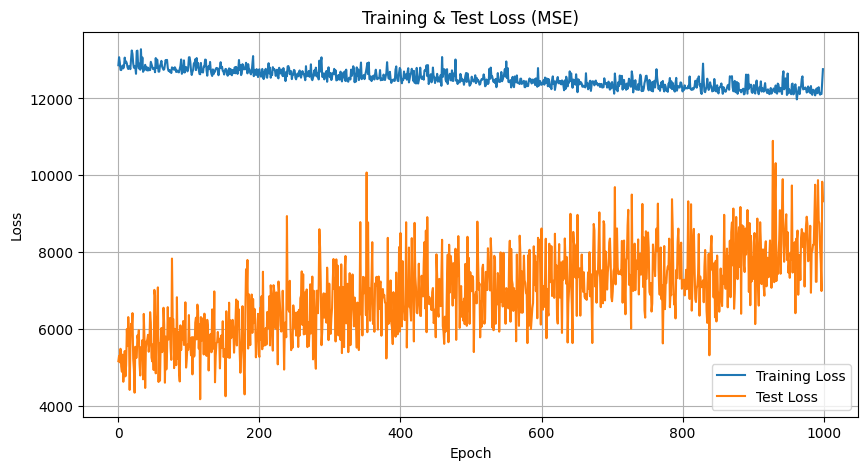


--- Final Model Evaluation ---
Mean Squared Error (MSE): 9323.6914
Root Mean Squared Error (RMSE): 96.5593
Mean Absolute Error (MAE): 76.9833
Mean Absolute Percentage Error (MAPE): 7.30%


In [126]:
# --- Plotting (Same as before) ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training & Test Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Final, More Detailed Evaluation ---
model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient calculation for evaluation
    # Get the final predictions on the test set
    y_predicted = model(X_test_tensor)
    
    # Define loss functions for MSE and MAE
    mse_loss_fn = nn.MSELoss()
    mae_loss_fn = nn.L1Loss()

    # Calculate the metrics
    final_mse = mse_loss_fn(y_predicted, y_test_tensor).item()
    final_rmse = torch.sqrt(torch.tensor(final_mse)).item()
    final_mae = mae_loss_fn(y_predicted, y_test_tensor).item()
    
    # Calculate MAPE using our new function
    final_mape = calculate_mape(y_test_tensor, y_predicted).item()

    print("\n--- Final Model Evaluation ---")
    print(f'Mean Squared Error (MSE): {final_mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {final_rmse:.4f}')
    print(f'Mean Absolute Error (MAE): {final_mae:.4f}')
    print(f'Mean Absolute Percentage Error (MAPE): {final_mape:.2f}%')

In [127]:
# ... your existing training script ...
# After the training loop and final evaluation ...

print("\n--- Saving model and scaler ---")

# 1. Save the model's state dictionary
# We save the state_dict() which is just the model's learned parameters.
# This is the recommended practice as it's more flexible.
torch.save(model.state_dict(), 'model_state.pth')
print("Model state saved to model_state.pth")

# 2. Save the scaler object
import joblib
joblib.dump(scaler, 'scaler.joblib')
print("Scaler object saved to scaler.joblib")


--- Saving model and scaler ---
Model state saved to model_state.pth
Scaler object saved to scaler.joblib
